# Project 5 : Predict markets stocks of Google, Facebook & Amazon.

## MAP670G - Data Stream (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

<br>
<img src="Google_Facebook_Amazon.PNG" width="600" height="600">
<br>

__Project 5 : Collect trading data using Yahoo finance API and use online regression to predict markets stocks of Google, Facebook & Amazon.__

__Option 2 :__ For each of these 5 countries, use 1 major industry stock data
For ex, in US Google,  in France BNP Paribas, in China Alibaba, in Russia or England, use a major international industry.
This option was initially given in the project.

For each option, each group should use at least 3 different data streams, with online and adaptive regression on RIVER (such as https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeRegressor/) and compare the performances with batch regression model (scikit-learn).

__ToDo:__ Compare online Regression vs Batch Regression and discuss the performance.

__Bonus :__ Use recent stock market data (from January to March 2022).

__Online resources:__ 
You can use the Python library to collect Yahoo Finance data in streaming https://pypi.org/project/yfinance/
You can compute time-series statistics and moving averages (MACD) for features engineering https://www.statsmodels.org/stable/tsa.html


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Libraries

In [2]:
!pip3 install --quiet -r requirements.txt

In [3]:
import sys 
print("Python version: {}". format(sys.version))

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import kafka
from kafka.admin import KafkaAdminClient, NewTopic
from kafka import KafkaProducer
from kafka import KafkaConsumer
print("kafka version : {}". format(kafka.__version__))

import yfinance as yf
print("yfinance version : {}". format(yf.__version__))

import statsmodels
print("statsmodels version : {}". format(statsmodels.__version__))
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
print("scikit-learn version : {}". format(sklearn.__version__))

import river
from river import base
from river import drift
from river import datasets
from river import anomaly
from river.anomaly.hst import HalfSpaceTrees, make_padded_tree
from river import compose
from river import metrics
from river import preprocessing

print("river version : {}". format(river.__version__))

import ipywidgets as widgets
print("ipywidgets version : {}". format(widgets.__version__))

import time
from time import perf_counter
from datetime import datetime, date, timedelta

from enum import Enum, auto

import math

import pprint

import json

import urllib.request

import warnings
warnings.filterwarnings('ignore')

print("====================================")

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
IPython version: 7.27.0
NumPy version: 1.20.3
SciPy version: 1.7.1
pandas version: 1.3.2
matplotlib version: 3.4.2
seaborn version : 0.11.2
kafka version : 2.0.2
yfinance version : 0.1.70
statsmodels version : 0.13.2
scikit-learn version : 1.0.1
river version : 0.9.0
ipywidgets version : 7.6.5


## Utility functions

In [4]:
def printmd(text, couleur=None):
    """
    Printing of the string text by choosing the style (for example bold) and the color (couleur)
    """
    colorstr = "<span style='color:{}'>{}</span>".format(couleur, text)
    display(Markdown(colorstr))

## Lancement des Serveurs
<p><b>LANCEMENT DU SERVEUR ZOOKEEPER ET DU SERVEUR KAFKA</b></p>
<p> Dans un <b>premier terminal</b>, lancer les commandes suivantes :
<p>cd %KAFKA_DIR%
<p>.\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
<p>  </p>
<p> Dans un <b>second terminal</b>, lancer les commandes suivantes
<p>cd %KAFKA_DIR%
<p>.\bin\windows\kafka-server-start.bat .\config\server.properties
<p>  -- </p>
<p>we assume that Zookeeper is running default on localhost:2181 and Kafka on localhost:9092.</p>

# Selection of data to be used (historical or recent data)

__HISTORICAL : Daily stock market data for the last 20 years__

__RECENT : Hourly stock market data from January 2021 to March 2022__

In [5]:
class Information(Enum):
    HISTORICAL = auto()
    RECENT = auto()

the_data_type = Information.RECENT

if the_data_type == Information.RECENT:
    print("Analysis of hourly stock market data from January 2021 to March 2022")
elif the_data_type == Information.HISTORICAL:
    print("Analysis of daily stock market data for the last 20 years")
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

Analysis of hourly stock market data from January 2021 to March 2022


# Get stock market data from Google, Facebook, Amazon, Total, Gazprom, Alibaba, BNP-Paribas, BP and Ferrari

## stock market data identifiers

In [6]:
the_GAF = ["google", "amazon", "facebook"]
All_the_companies = ["google",
                     "facebook",
                     "amazon",
                     "total",
                     "gazprom",
                     "alibaba",
                     "bnp_paribas",
                     "BP",
                     "ferrari"]

tick = {}
tick["google"] = "GOOG"
tick["facebook"] = "FB"
tick["amazon"] = "AMZN"
tick["total"] = "TTE"
tick["gazprom"] = "OGZPY"
tick["alibaba"] = "BABA"
tick["bnp_paribas"] = "BNPQY"
tick["BP"] = "BP"
tick["ferrari"] = "RACE"

the_GAF_tickers = " ".join(map(str, [v for k, v in tick.items() if k in the_GAF]))
all_the_tickers = " ".join(map(str, [v for v in tick.values()]))
GAF_tick = yf.Tickers(the_GAF_tickers)
ALL_tick = yf.Tickers(all_the_tickers)

google = GAF_tick.tickers[tick["google"]]
facebook = GAF_tick.tickers[tick["facebook"]]
amazon = GAF_tick.tickers[tick["amazon"]]

total = yf.Ticker(tick["total"])
gazprom = yf.Ticker(tick["gazprom"])
alibaba = yf.Ticker(tick["alibaba"])
bnp_paribas = yf.Ticker(tick["bnp_paribas"])
BP = yf.Ticker(tick["BP"])
ferrari = yf.Ticker(tick["ferrari"])

## Get information on companies

In [7]:
google_info = google.info
facebook_info = facebook.info
amazon_info = amazon.info
total_info = total.info
gazprom_info = gazprom.info
alibaba_info = alibaba.info
bnp_paribas_info = bnp_paribas.info
BP_info = BP.info
ferrari_info = ferrari.info

stock_info = [google_info, facebook_info, amazon_info,
              total_info, gazprom_info, alibaba_info,
              bnp_paribas_info, BP_info, ferrari_info]

for i, info in enumerate(stock_info):
    print("---------- {} ----------".format(All_the_companies[i]))
    print("{} - sector: {}; country: {}; logo: {}" \
        .format(info["shortName"],
                info["sector"],
                info["country"],
                info["logo_url"]))
    print("")

---------- google ----------
Alphabet Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/abc.xyz

---------- facebook ----------
Meta Platforms, Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/investor.fb.com

---------- amazon ----------
Amazon.com, Inc. - sector: Consumer Cyclical; country: United States; logo: https://logo.clearbit.com/amazon.com

---------- total ----------
TotalEnergies SE - sector: Energy; country: France; logo: https://logo.clearbit.com/totalenergies.com

---------- gazprom ----------
GAZPROM PUBLIC JOINT STOCK COMP - sector: Energy; country: Russia; logo: https://logo.clearbit.com/gazprom.com

---------- alibaba ----------
Alibaba Group Holding Limited - sector: Consumer Cyclical; country: China; logo: https://logo.clearbit.com/alibabagroup.com

---------- bnp_paribas ----------
BNP PARIBAS ADR EACH REPR 1/2 O - sector: Financial Services; country: France; logo: https://l

## Set parameters for yfinance package

In [8]:
if the_data_type == Information.RECENT:
    deb = "2021-01-01"
    fin = "2022-03-31"
    interval = "1h"
    init_type = True
elif the_data_type == Information.HISTORICAL:
    deb = "2002-01-01"
    fin = "2022-03-31"
    interval = "1d"
    init_type = True
else:
    init_type = False
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

## Get stock market data

In [9]:
if init_type:
    print("Get stock market data (interval={}) from {} to {}.".format(interval, deb, fin))
    temps = perf_counter()
    data = yf.download(all_the_tickers, start=deb, end=fin, interval=interval, group_by='ticker')
    temps_recuperation_donnees = perf_counter() - temps
    print("CPU time = {:.3f} seconds".format(temps_recuperation_donnees))
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

Get stock market data (interval=1h) from 2021-01-01 to 2022-03-31.
[*********************100%***********************]  9 of 9 completed
CPU time = 3.367 seconds


## Describe the stock market data collected

In [10]:
data

RACE                                      \
                                 Open        High         Low       Close   
2021-01-04 09:30:00-05:00  231.889999  232.309998  230.470001  230.729996   
2021-01-04 10:30:00-05:00  230.589996  231.041397  228.850006  230.850006   
2021-01-04 11:30:00-05:00  230.800003  230.800003  227.220001  228.107697   
2021-01-04 12:30:00-05:00  227.910004  228.970001  227.119995  228.949997   
2021-01-04 13:30:00-05:00  228.720001  229.020004  226.710007  226.955002   
...                               ...         ...         ...         ...   
2022-03-18 12:51:11-04:00         NaN         NaN         NaN         NaN   
2022-03-18 12:51:18-04:00         NaN         NaN         NaN         NaN   
2022-03-18 12:51:20-04:00         NaN         NaN         NaN         NaN   
2022-03-18 12:51:23-04:00         NaN         NaN         NaN         NaN   
2022-03-18 12:51:24-04:00         NaN         NaN         NaN         NaN   

                                                       GOOG               \
                            Adj Close   Volume         Open         High   
2021-01-04 09:30:00-05:00  230.729996      0.0  1758.420044  1760.640015   
2021-01-04 10:30:00-05:00  230.850006  37451.0  1749.130005  1757.816040   
2021-01-04 11:30:00-05:00  228.107697  49115.0  1730.550049  1731.800049   
2021-01-04 12:30:00-05:00  228.949997  17811.0  1716.150024  1723.199951   
2021-01-04 13:30:00-05:00  226.955002  34929.0  1722.466187  1729.150024   
...                               ...      ...          ...          ...   
2022-03-18 12:51:11-04:00         NaN      NaN          NaN          NaN   
2022-03-18 12:51:18-04:00         NaN      NaN  2711.439941  2711.439941   
2022-03-18 12:51:20-04:00         NaN      NaN          NaN          NaN   
2022-03-18 12:51:23-04:00         NaN      NaN          NaN          NaN   
2022-03-18 12:51:24-04:00         NaN      NaN          NaN          NaN   

                                                     ...      BNPQY  \
                                   Low        Close  ...        Low   
2021-01-04 09:30:00-05:00  1740.949951  1748.239990  ...  26.180000   
2021-01-04 10:30:00-05:00  1725.000000  1730.589966  ...  26.145000   
2021-01-04 11:30:00-05:00  1710.880005  1716.534424  ...  26.059999   
2021-01-04 12:30:00-05:00  1707.849976  1722.277466  ...  26.110001   
2021-01-04 13:30:00-05:00  1720.229980  1724.395020  ...  26.230000   
...                                ...          ...  ...        ...   
2022-03-18 12:51:11-04:00          NaN          NaN  ...        NaN   
2022-03-18 12:51:18-04:00  2711.439941  2711.439941  ...        NaN   
2022-03-18 12:51:20-04:00          NaN          NaN  ...        NaN   
2022-03-18 12:51:23-04:00          NaN          NaN  ...        NaN   
2022-03-18 12:51:24-04:00          NaN          NaN  ...        NaN   

                                                                   FB  \
                               Close  Adj Close    Volume        Open   
2021-01-04 09:30:00-05:00  26.219999  26.219999       0.0  273.750000   
2021-01-04 10:30:00-05:00  26.375000  26.375000   16875.0  271.269989   
2021-01-04 11:30:00-05:00  26.115000  26.115000  134307.0  268.220001   
2021-01-04 12:30:00-05:00  26.275000  26.275000    6955.0  266.920013   
2021-01-04 13:30:00-05:00  26.290001  26.290001   13003.0  268.440002   
...                              ...        ...       ...         ...   
2022-03-18 12:51:11-04:00        NaN        NaN       NaN         NaN   
2022-03-18 12:51:18-04:00        NaN        NaN       NaN         NaN   
2022-03-18 12:51:20-04:00        NaN        NaN       NaN         NaN   
2022-03-18 12:51:23-04:00        NaN        NaN       NaN         NaN   
2022-03-18 12:51:24-04:00        NaN        NaN       NaN  214.012100   

                                                                           \
                                 High         Low       Close   Adj Close   
2021-01-04 09:

In [11]:
data.describe()

RACE                                                      \
              Open         High          Low        Close    Adj Close   
count  2130.000000  2130.000000  2130.000000  2130.000000  2130.000000   
mean    219.770388   220.413365   219.113277   219.766032   219.766032   
std      20.566265    20.613809    20.492890    20.536955    20.536955   
min     180.059998   181.940002   178.869995   180.289993   180.289993   
25%     206.392498   206.957497   205.802498   206.484997   206.484997   
50%     214.110001   214.835007   213.389999   214.262497   214.262497   
75%     225.440002   225.887501   224.558746   225.505352   225.505352   
max     278.489990   278.779999   276.779999   278.250000   278.250000   

                             GOOG                                         ...  \
              Volume         Open         High          Low        Close  ...   
count    2130.000000  2130.000000  2130.000000  2130.000000  2130.000000  ...   
mean    47204.077465  2544.135674  2552.632744  2535.220604  2544.118445  ...   
std     45424.684565   344.752846   344.802035   343.966298   344.320723  ...   
min         0.000000  1706.187500  1723.199951  1700.000000  1716.534424  ...   
25%     20116.250000  2292.678833  2299.066162  2286.705078  2293.699951  ...   
50%     33857.000000  2640.655029  2651.954956  2630.424927  2642.119995  ...   
75%     57495.250000  2833.262573  2841.971985  2823.790039  2832.802429  ...   
max    517906.000000  3037.270020  3042.000000  3016.280029  3027.239990  ...   

             BNPQY                                                   FB  \
               Low        Close    Adj Close        Volume         Open   
count  2130.000000  2130.000000  2130.000000  2.130000e+03  2130.000000   
mean     31.725531    31.819606    31.819606  4.098635e+04   309.811597   
std       2.839720     2.838476     2.838476  1.471275e+05    46.549567   
min      24.000000    24.025000    24.025000  0.000000e+00   186.059998   
25%      30.290751    30.396250    30.396250  8.300000e+03   275.158478   
50%      31.750000    31.850000    31.850000  1.593850e+04   324.923645   
75%      33.808926    33.902625    33.902625  2.992375e+04   341.498749   
max      38.290001    38.306999    38.306999  2.628363e+06   383.559998   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  2130.000000  2130.000000  2130.000000  2130.000000  2.130000e+03  
mean    311.134207   308.448981   309.810982   309.810982  2.836724e+06  
std      46.466969    46.621520    46.565215    46.565215  2.873145e+06  
min     187.699997   185.820007   186.059998   186.059998  0.000000e+00  
25%     276.457497   273.899994   274.897514   274.897514  1.429731e+06  
50%     326.240005   323.559998   324.812500   324.812500  2.073308e+06  
75%     342.470001   340.440010   341.369499   341.369499  3.363236e+06  
max     384.329987   382.989990   383.600006   383.600006  7.736695e+07  

[8 rows x 54 columns]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2021-01-04 09:30:00-05:00 to 2022-03-18 12:51:24-04:00
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (RACE, Open)        2130 non-null   float64
 1   (RACE, High)        2130 non-null   float64
 2   (RACE, Low)         2130 non-null   float64
 3   (RACE, Close)       2130 non-null   float64
 4   (RACE, Adj Close)   2130 non-null   float64
 5   (RACE, Volume)      2130 non-null   float64
 6   (GOOG, Open)        2130 non-null   float64
 7   (GOOG, High)        2130 non-null   float64
 8   (GOOG, Low)         2130 non-null   float64
 9   (GOOG, Close)       2130 non-null   float64
 10  (GOOG, Adj Close)   2130 non-null   float64
 11  (GOOG, Volume)      2130 non-null   float64
 12  (BABA, Open)        2130 non-null   float64
 13  (BABA, High)        2130 non-null   float64
 14  (BABA, Low)         2130 non-null   float64
 15  (BABA, 

In [13]:
data.columns

MultiIndex([( 'RACE',      'Open'),
            ( 'RACE',      'High'),
            ( 'RACE',       'Low'),
            ( 'RACE',     'Close'),
            ( 'RACE', 'Adj Close'),
            ( 'RACE',    'Volume'),
            ( 'GOOG',      'Open'),
            ( 'GOOG',      'High'),
            ( 'GOOG',       'Low'),
            ( 'GOOG',     'Close'),
            ( 'GOOG', 'Adj Close'),
            ( 'GOOG',    'Volume'),
            ( 'BABA',      'Open'),
            ( 'BABA',      'High'),
            ( 'BABA',       'Low'),
            ( 'BABA',     'Close'),
            ( 'BABA', 'Adj Close'),
            ( 'BABA',    'Volume'),
            ('OGZPY',      'Open'),
            ('OGZPY',      'High'),
            ('OGZPY',       'Low'),
            ('OGZPY',     'Close'),
            ('OGZPY', 'Adj Close'),
            ('OGZPY',    'Volume'),
            (  'TTE',      'Open'),
            (  'TTE',      'High'),
            (  'TTE',       'Low'),
            (  'TTE',     'C

## Plot the Close price of the stock market data collected

In [14]:
def plot_closing(data, company_name, tick, short_window=20, long_window=100, unite="days"):
    the_data = data[(tick, "Close")]
    ax = the_data.plot(figsize=(15,8),
                       label="{}".format(tick),
                       title="Closing price (in USD) of the stock market for {}" \
                             .format(company_name))
    # Calculate the <short_window> and <long_window> moving averages of the closing prices
    if short_window is not None:
        short_rolling = the_data.rolling(window=short_window).mean()
        short_rolling.plot(label="{} {} rolling".format(short_window, unite))
    if long_window is not None:
        long_rolling = the_data.rolling(window=long_window).mean()
        long_rolling.plot(label="{} {} rolling".format(long_window, unite))
    ax.legend()
    plt.show()

In [15]:
# Set the windows for moving averages of the closing prices
if the_data_type == Information.RECENT:
    unite = "hours"
    short_window = 7                               # 7 hours = 1 day
    long_window = 35                               # 35 hours = 1 week
elif the_data_type == Information.HISTORICAL:
    unite = "days"
    short_window = 20                              # time in days
    long_window = 100                              # time in days
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

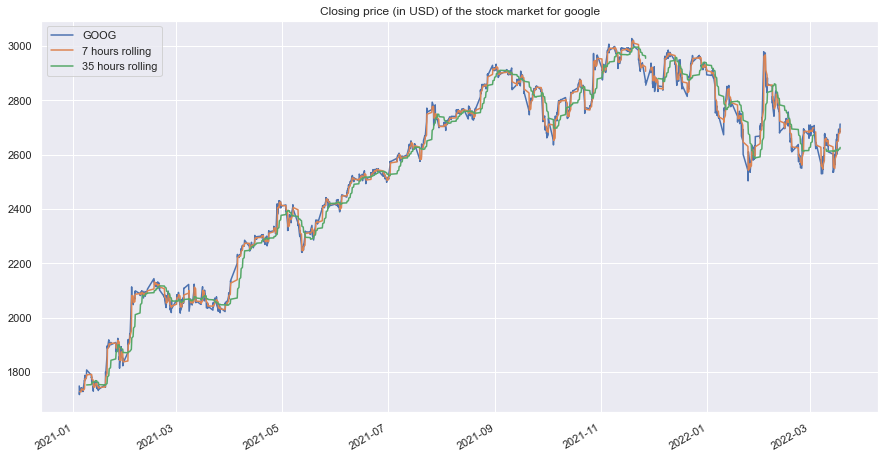

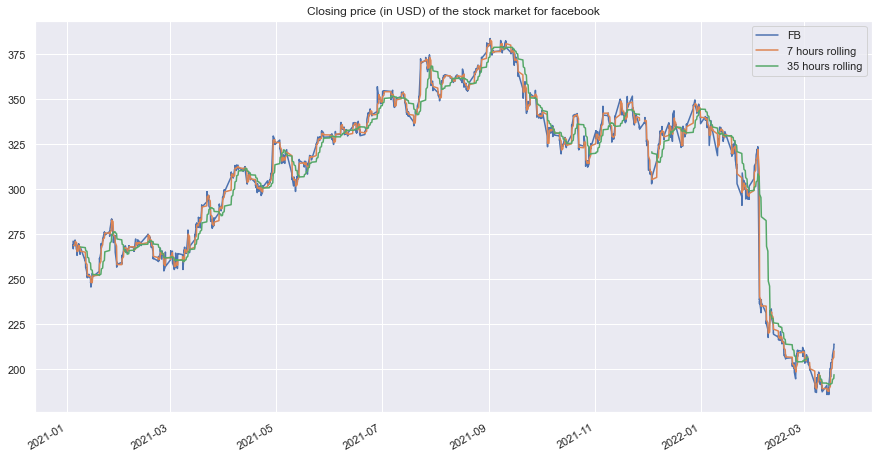

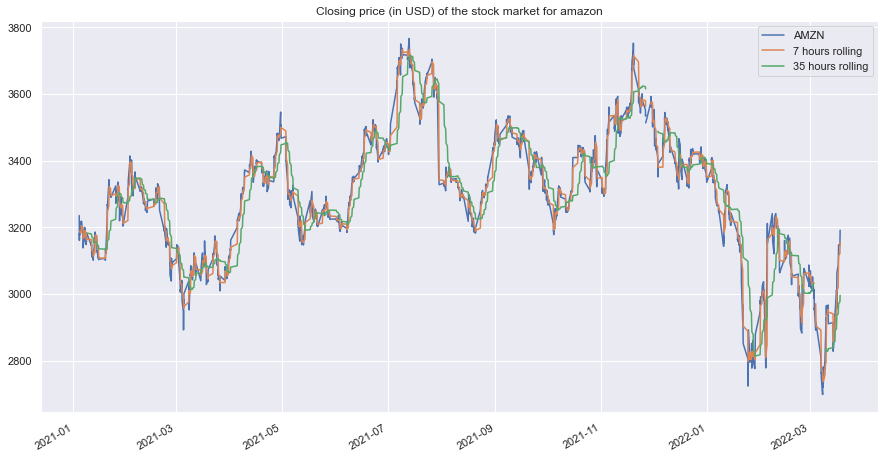

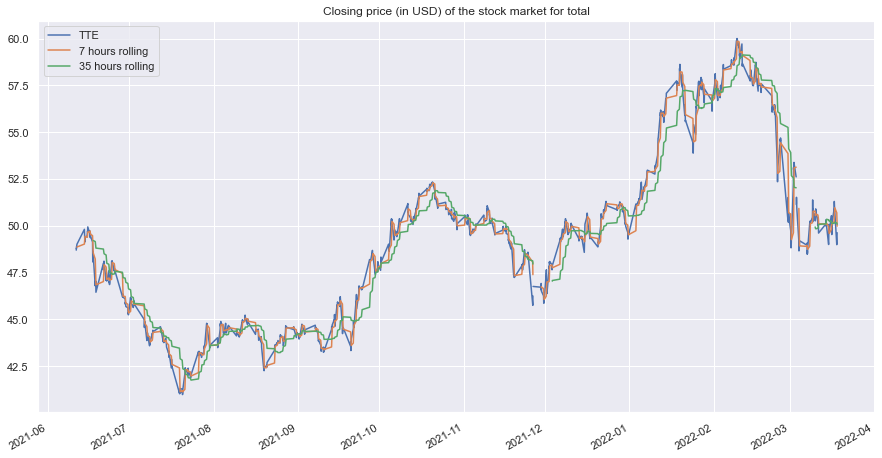

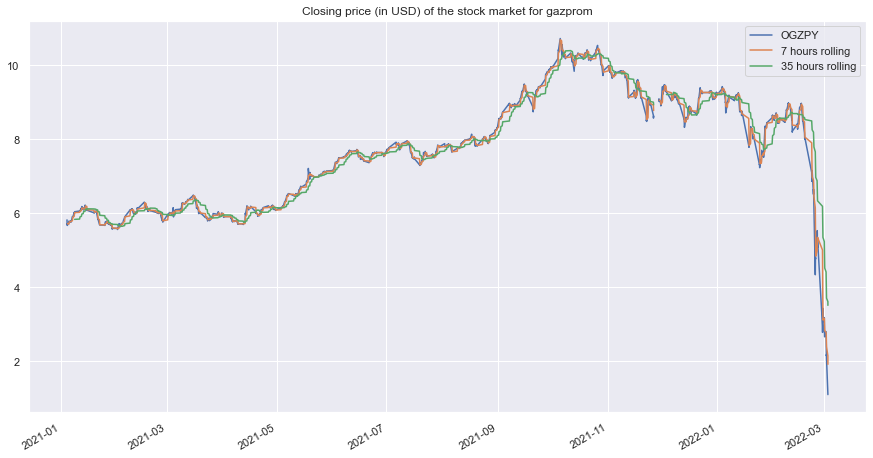

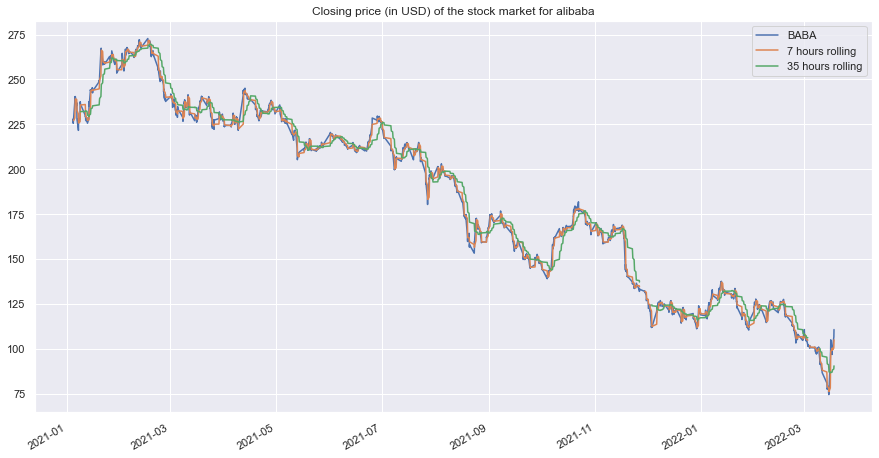

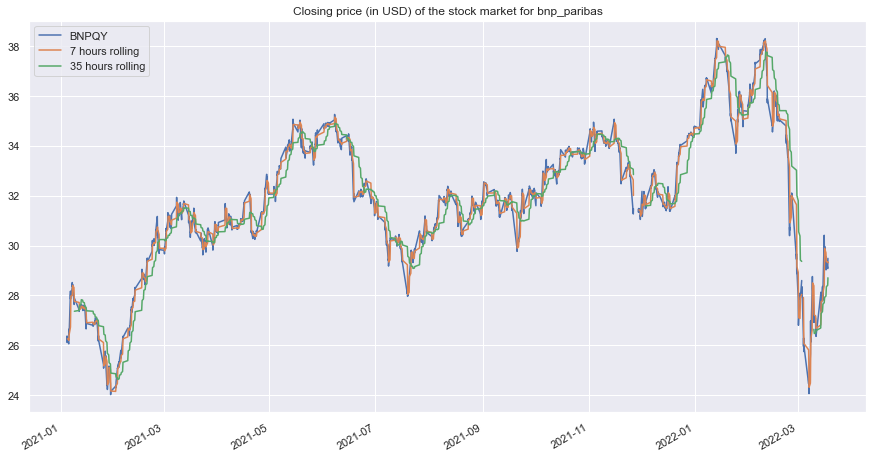

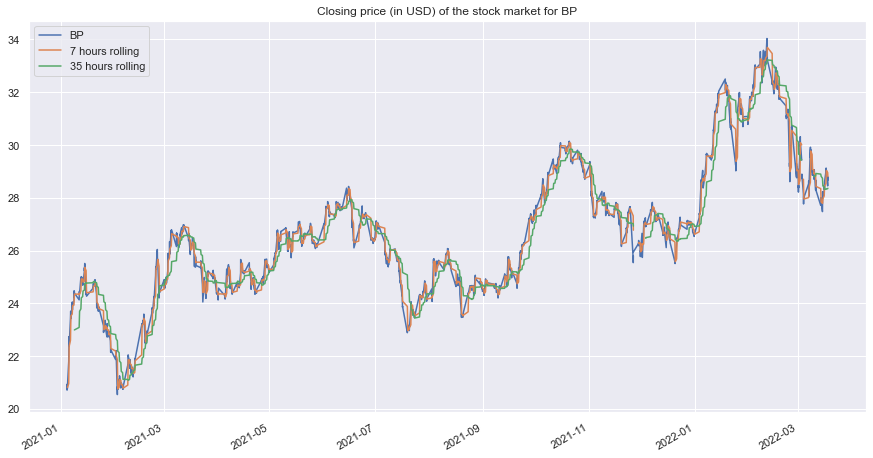

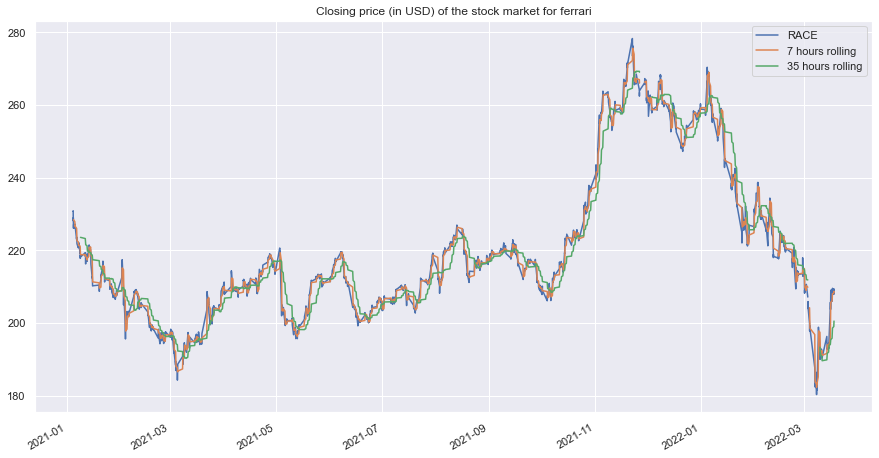

In [16]:
for company in All_the_companies:
    plot_closing(data,
                 company,
                 tick[company],
                 short_window=short_window,
                 long_window=long_window,
                 unite=unite)

# Stock market prediction using batch regression

In [17]:
No_Company = 0              # value from 0 to 8

The_selected_company = All_the_companies[No_Company]
print("The selected company is {}".format(The_selected_company))

The selected company is google


In [18]:
Batch_ML_result = {}
Batch_ML_result[The_selected_company] = {}

In [19]:
if the_data_type == Information.RECENT:
    date_deb_test = datetime(2022, 3, 1)
    date_fin_train = date_deb_test - timedelta(hours=1)
elif the_data_type == Information.HISTORICAL:
    date_deb_test = datetime(2022, 1, 1)
    date_fin_train = date_deb_test - timedelta(days=1)
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

## Split the data between the train and test datasets.

In [20]:
Close_price_for_the_selected_company = data[(tick[The_selected_company], "Close")]

# Delete the NaN values
data_clean = Close_price_for_the_selected_company.dropna()

data_train = data_clean[:date_fin_train]
data_test = data_clean[date_deb_test:]

data_test

2022-03-01 09:30:00-05:00    2709.040039
2022-03-01 10:30:00-05:00    2703.479980
2022-03-01 11:30:00-05:00    2689.870117
2022-03-01 12:30:00-05:00    2668.969971
2022-03-01 13:30:00-05:00    2680.090088
                                ...     
2022-03-18 09:30:00-04:00    2683.290039
2022-03-18 10:30:00-04:00    2703.790039
2022-03-18 11:30:00-04:00    2710.540039
2022-03-18 12:30:00-04:00    2712.600098
2022-03-18 12:51:18-04:00    2711.439941
Name: (GOOG, Close), Length: 96, dtype: float64

## ARMA Model

In [21]:
def Modele_ARIMA(Serie, p, q, d = 0):
    """
    Input parameters : Time series and parameters p, d, q (default value of d is 0 : ARMA model)
    
    Return : Model trained on the time series data
    """
    
    # Model building from the Series data
    Modele = ARIMA(Serie, order=(p, d, q)).fit()
    
    # Model quality
    print(Modele.summary())
    
    # Extraction of residue
    Residu = Modele.resid
    
    # Statistical tests on the residue
    
    # 1 - White noise
    df_result = acorr_ljungbox(Residu, boxpierce=True)
    p_value_Box_Pierce = df_result["bp_pvalue"].iloc[0]
    
    # 2 - Normal distribution
    statistique, p_value_Shapiro = stats.shapiro(Residu)
    
    # 3 - Stationarity
    adf, p_value_ADF, usedlag, nobs, critical_values, icbest = adfuller(Residu)
    kpss_stat, p_value_KPSS, lags, crit = kpss(Residu)

    
    print("")
    print("\nBox-Pierce test: pvalue = {}".format(p_value_Box_Pierce))
    if (p_value_Box_Pierce > 0.05):
        print("The residual is a white noise because the hypothesis H0 is satisfied")
    else:
        print("The residual is not a white noise because the hypothesis H0 is not satisfied")
    
    print("\nShapiro-Wilk test: pvalue = {}".format(p_value_Shapiro))
    if (p_value_Shapiro > 0.05):
        print("The residual follows a Normal distribution because the hypothesis H0 is verified")
    else:
        print("The residual does not follow a Normal distribution because the hypothesis H0 is not verified")

    print("\nAugmented Dickey Fuller Test: pvalue = {}".format(p_value_ADF))
    if (p_value_ADF > 0.05):
        print("The residual is not a stationary process because the hypothesis H0 is verified")
    else:
        print("The residual is a stationary process because the hypothesis H0 is not verified")
        
    print("\nKwiatkowski-Phillips-Schmidt-Shin test: pvalue = {}".format(p_value_KPSS))
    if (p_value_KPSS > 0.05):
        print("The residual is a stationary process because the hypothesis H0 is verified")
    else:
        print("The residual is not a stationary process because the hypothesis H0 is not verified")
    
    return Modele

In [22]:
def Modele_Predict(Modele, Test):
    """
    Input data: Trained ARIMA model and time series Test
    
    Return: the prediction score and the dataframe with the values predicted by the model 
    """
    Valeurs_predites = Modele.get_forecast(len(Test))
    df_Prediction = Valeurs_predites.summary_frame()
    df_Prediction["date"] = Test.index.tolist()
    df_Prediction.set_index("date", inplace=True)
    df_Prediction.drop(["mean_se"], axis="columns", inplace=True)
    df_Prediction.rename(columns={"mean": "Prediction", 
                                  "mean_ci_lower": "Borne_Inf_95",
                                  "mean_ci_upper": "Borne_Sup_95"}, inplace=True)
    
    # Scores of the prediction
    MAE = mean_absolute_error(Test, df_Prediction["Prediction"])
    
    return (MAE, df_Prediction)

In [23]:
def plot_predict_ARMA(The_selected_company, data_clean, The_model, df_Prediction, p=1, q=1):
    """
    Plot the prediction values and the true values of the closing stock price
    """
    deb = data_clean.head(1).index.strftime("%d/%m/%Y %H:%M:%S").tolist()[0]
    fin = data_clean.tail(1).index.strftime("%d/%m/%Y %H:%M:%S").tolist()[0]
    # Link between the train values and the predict values to avoid a gap in the curve
    df_Lien_Train_Test = pd.concat([The_model.fittedvalues.tail(1),
                                    df_Prediction["Prediction"].head(1)])

    (fig, ax) = plt.subplots(figsize=(15, 8))
    ax.plot(data_clean, color="red", label="True values")
    ax.plot(The_model.fittedvalues, color="blue", label="Train model")
    ax.plot(df_Lien_Train_Test, color="blue")
    ax.plot(df_Prediction["Prediction"], color="green", label="Prediction")
    ax.fill_between(df_Prediction.index, 
                    df_Prediction['Borne_Inf_95'], 
                    df_Prediction['Borne_Sup_95'], color='yellow', alpha=0.6, label="95% confidence interval")
    Titre = "ARMA({},{}) model of the closing price for the {} stock between {} and {}" \
        .format(p, q, The_selected_company, deb, fin)
    plt.title(Titre)
    plt.legend(loc='upper left')
    plt.show()

### Determination of the model parameters from the AutoCorrelation Function (ACF) and the Partial AutoCorrelation Function (PACF)

In [24]:
# The data describe the closing price throughout the year.
if the_data_type == Information.RECENT:
    # Without any a priori information, we plot the autocorrelation 
    # with lags = 7 hours (1 day), 35 hours (1 week) and 140 hours (1 month)
    lags = [140, 35, 7]
elif the_data_type == Information.HISTORICAL:
    # Without any a priori information, we plot the autocorrelation 
    # with lags = 5 days (1 week), 20 days (1 month) and 240 days (1 year)
    lags = [240, 20, 5]
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

In [25]:
def plot_ACF_and_PACF(data_train, lags):
    for lag in lags:
        plt.figure(figsize=(12, 8) )
        plt.subplot(211)
        courbe_1 = plot_acf(data_train, lags=lag, ax=plt.gca())
        plt.subplot(212)
        courbe_2 = plot_pacf(data_train, lags=lag, ax=plt.gca())
        plt.show()

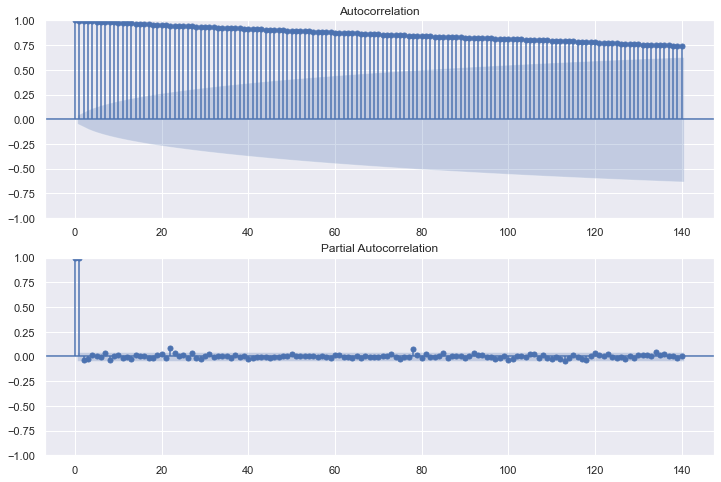

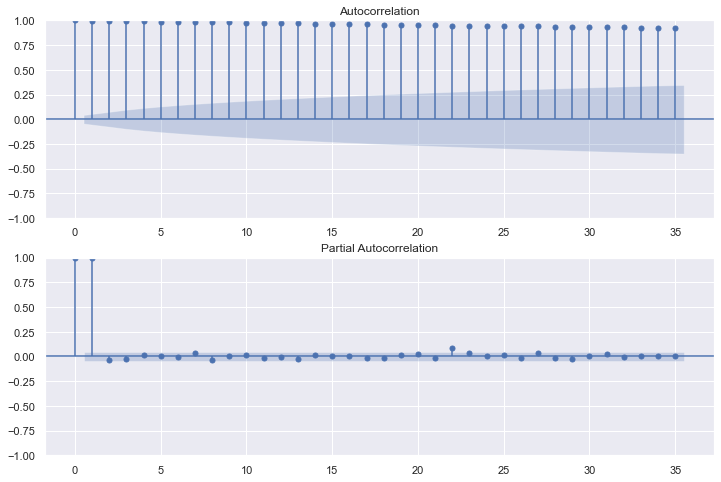

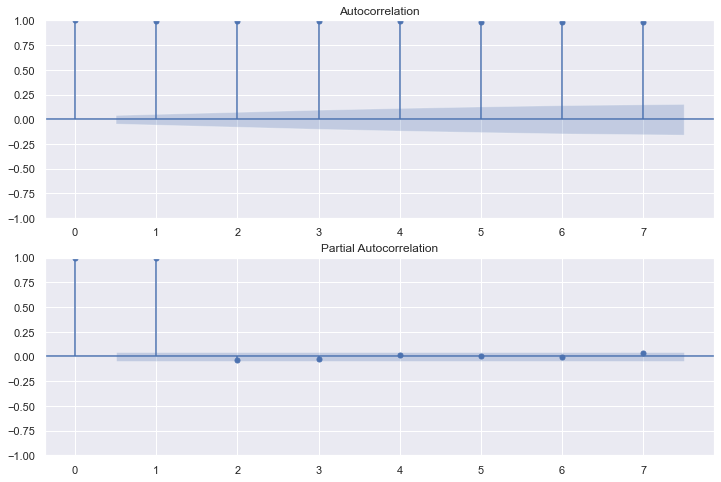

In [26]:
plot_ACF_and_PACF(data_train, lags)

<div class="alert alert-block alert-info">
<p><b>COMMENT :</b></p>

<p>The p and q values of an ARMA model can be derived using two tools:</p>

<p>- The autocorrelogram for the parameter q of the MA model (Moving Average Model).</p>

<p>- The partial autocorrelogram for the parameter p of the AR model (Auto-Regressive Model).</p>

<p>For each curve, we consider the smallest value that is significantly outside the confidence interval. We find <b>p = 1 and q = 1.</b></p>

<p><b>CONCLUSION :</b> The time series 'Stock market' can be modeled by an ARMA(1,1) process</p>
</div>

In [27]:
print("\n---------------------- Close price train for {} ----------------------".format(The_selected_company))
temps = perf_counter()

Modele_11 = Modele_ARIMA(data_train, 1, 1)

temps_train_Modele_11 = perf_counter() - temps
Batch_ML_result[The_selected_company]["CPU_time"] = temps_train_Modele_11
print("")
print("+--------------------------+")
print("| CPU time = {:.3f} seconds |".format(temps_train_Modele_11))
print("+--------------------------+")


---------------------- Close price train for google ----------------------
                               SARIMAX Results                                
Dep. Variable:      ('GOOG', 'Close')   No. Observations:                 2034
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8426.108
Date:                Fri, 18 Mar 2022   AIC                          16860.216
Time:                        17:51:45   BIC                          16882.687
Sample:                             0   HQIC                         16868.460
                               - 2034                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2539.5945    388.208      6.542      0.000    1778.721    3300.468
ar.L1          0.9994      0.001   1231.587      0.000 

In [28]:
MAE, df_Prediction_11 = Modele_Predict(Modele_11, data_test)
print("\nMean Absolute Error of the prediction = {:.2f} USD".format(MAE))
Batch_ML_result[The_selected_company]["MAE"] = MAE
df_Prediction_11


Mean Absolute Error of the prediction = 59.86 USD


"(GOOG, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-01 09:30:00-05:00,2698.933467,2669.120838,2728.746095
2022-03-01 10:30:00-05:00,2698.841630,2655.878674,2741.804586
2022-03-01 11:30:00-05:00,2698.749846,2645.818424,2751.681269
2022-03-01 12:30:00-05:00,2698.658116,2637.367384,2759.948847
2022-03-01 13:30:00-05:00,2698.566438,2629.935018,2767.197857
...,...,...,...
2022-03-18 09:30:00-04:00,2690.789428,2401.631674,2979.947181
2022-03-18 10:30:00-04:00,2690.702285,2400.058345,2981.346225
2022-03-18 11:30:00-04:00,2690.615193,2398.494327,2982.736058


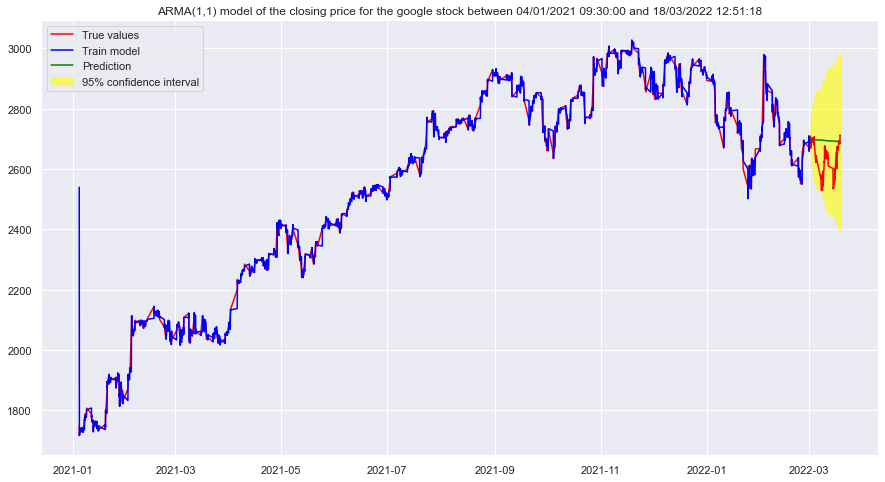

In [29]:
plot_predict_ARMA(The_selected_company, data_clean, Modele_11, df_Prediction_11)

# Processing of stock market data in Kafka

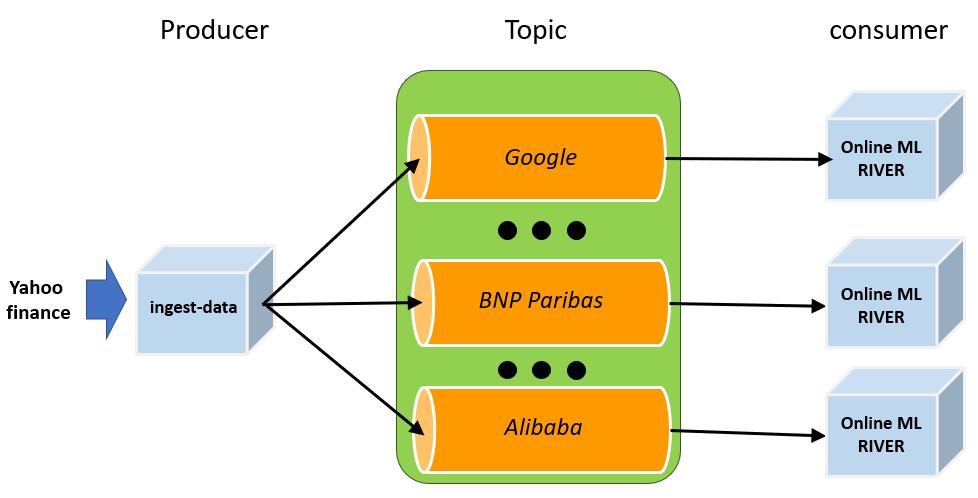

__We create a Kafka topic for each company and stream the stock data retrieved with yfinance into these topics.
In another notebook, we will retrieve this stock market data to apply a Machine Learning model with RIVER.__

## Notebook settings

In [30]:
trace_ingest_data = True
Nb_to_print = 500

## Creation of topics if needed

In [31]:
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id="Project_DataStream")

topic_name = {}
for company in All_the_companies:
    topic_name[company] = company

    if topic_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

# Add a topic to store Machine Learning results
topic_result_name = "result_ML"

if topic_result_name not in admin_client.list_topics():
    topic_list = []
    topic_list.append(NewTopic(name=topic_result_name, num_partitions=1, replication_factor=1))
    admin_client.create_topics(new_topics=topic_list, validate_only=False)

## Kafka producer : results of Batch regression

In [33]:
producer = KafkaProducer(bootstrap_servers="localhost:9092")
pp = pprint.PrettyPrinter()

print("---------- {} ----------".format(The_selected_company))
Batch_ML_result[The_selected_company]["date"] = int(time.time()) * 1000
Batch_ML_result[The_selected_company]["Regression"] = "Batch"
Batch_ML_result[The_selected_company]["Company"] = The_selected_company
pp.pprint(Batch_ML_result[The_selected_company])

producer.send(topic_result_name, json.dumps(Batch_ML_result[The_selected_company]).encode())

---------- google ----------
{'CPU_time': 3.093003499999952,
 'Company': 'google',
 'MAE': 59.86270677164007,
 'Regression': 'Batch',
 'date': 1647622716000}


## Kafka Producer : ingest_data

In [34]:
if trace_ingest_data:
    print("-----  INGEST DATA FROM YAHOO FINANCE  ----")

Nb_items = {}
for company in All_the_companies:
    Nb_items[company] = 0

try:
    for date, col in data.iterrows():        
        ligne = {}
        for company in All_the_companies:
            ligne[tick[company]] = {}
            ligne[tick[company]]["date"] = int(datetime.timestamp(date))*1000

        for indice in col.index:
            ligne[indice[0]][indice[1]] = col[indice]

        for company in All_the_companies:
            if not math.isnan(ligne[tick[company]]["Open"]):
                Nb_items[company] += 1
                producer.send(topic_name[company], json.dumps(ligne[tick[company]]).encode())
            
                if Nb_items[company] == 1:
                    if trace_ingest_data:
                        print("---------- {} ----------".format(company))
                        pp.pprint(ligne[tick[company]])
                        print("")

                if Nb_items[company] % Nb_to_print == 0:
                    if trace_ingest_data:
                        print("{} - {} records sent to the Kafka topic {}" \
                              .format(time.strftime("%d/%m/%Y %H:%M:%S"),
                                      Nb_items[company],
                                      company))

except KeyboardInterrupt:
    if trace_ingest_data:
        print ("----------  END OF INGEST DATA  ----------")
except Exception as e:
    print("An arror has occurred")
    print(e)

-----  INGEST DATA FROM YAHOO FINANCE  ----
---------- google ----------
{'Adj Close': 1748.239990234375,
 'Close': 1748.239990234375,
 'High': 1760.6400146484375,
 'Low': 1740.949951171875,
 'Open': 1758.4200439453125,
 'Volume': 241052.0,
 'date': 1609770600000}

---------- facebook ----------
{'Adj Close': 271.1700134277344,
 'Close': 271.1700134277344,
 'High': 273.8999938964844,
 'Low': 269.9800109863281,
 'Open': 273.75,
 'Volume': 2708653.0,
 'date': 1609770600000}

---------- amazon ----------
{'Adj Close': 3235.080078125,
 'Close': 3235.080078125,
 'High': 3271.175048828125,
 'Low': 3217.0,
 'Open': 3271.03125,
 'Volume': 817344.0,
 'date': 1609770600000}

---------- gazprom ----------
{'Adj Close': 5.820000171661377,
 'Close': 5.820000171661377,
 'High': 5.829999923706055,
 'Low': 5.800000190734863,
 'Open': 5.809999942779541,
 'Volume': 0.0,
 'date': 1609770600000}

---------- alibaba ----------
{'Adj Close': 227.75,
 'Close': 227.75,
 'High': 230.3800048828125,
 'Low': 225.